# Credit

This notebook is based on the following notebook by @yasufuminakama. I would like to take this opportunity to thank him.

Please vote for his notebook as well.

https://www.kaggle.com/yasufuminakama/cassava-resnext50-32x4d-starter-training

# Summary of this notebook

In this notebook, we are gonna build the nocall detector. (0:nocall, 1:somebird singing)

The output of the models would be probability value.

# input & output of this notebook

[input]

freefield1010 data

https://www.kaggle.com/startjapan/ff1010bird-duration7

[output]

Nocall detector models are outputted.

In [1]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [2]:
import torch

class CFG:
    print_freq=100
    num_workers=4
    model_name= 'resnext50_32x4d'
    dim=(128, 281)
    scheduler='CosineAnnealingWarmRestarts'
    epochs=10
    lr=1e-4
    T_0=10 # for CosineAnnealingWarmRestarts
    min_lr=5e-7 # for CosineAnnealingWarmRestarts
    batch_size=32
    weight_decay=1e-6
    max_grad_norm=1000
    seed=42
    target_size=2
    target_col='hasbird'
    n_fold = 5
    pretrained = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd

train = pd.read_csv('../input/ff1010bird-duration7/rich_metadata.csv')
train.loc[train['hasbird']==0, 'filepath'] = '../input/ff1010bird-duration7/nocall/' + train.query('hasbird==0')['filename'] + '.npy'
train.loc[train['hasbird']==1, 'filepath'] = '../input/ff1010bird-duration7/bird/' + train.query('hasbird==1')['filename'] + '.npy'

train = train.dropna().reset_index(drop=True)

folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  hasbird
0     0          1151
      1           387
1     0          1151
      1           387
2     0          1151
      1           387
3     0          1151
      1           387
4     0          1151
      1           387
dtype: int64


In [4]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

!pip install timm
import timm

import warnings 
warnings.filterwarnings('ignore')

     |████████████████████████████████| 346 kB 1.3 MB/s 


In [5]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def get_confusion_matrix(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [6]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_paths = df['filepath'].values
        self.labels = df['hasbird'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_paths[idx]
        file_path = file_name
        image = np.load(file_path)
        image = image.transpose(1,2,0)
        image = np.squeeze(image)
        image = np.stack((image,)*3, -1)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label

In [7]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.augmentations.transforms.JpegCompression(p=0.5),
            A.augmentations.transforms.ImageCompression(p=0.5, compression_type=A.augmentations.transforms.ImageCompression.ImageCompressionType.WEBP),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [8]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(
                   epoch+1, step+1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step+1, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [10]:
def train_loop(train_folds, valid_folds):

    LOGGER.info(f"========== training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    def get_scheduler(optimizer):
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(CFG.device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    scores = []
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, CFG.device)
        
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, CFG.device)
        valid_labels = valid_folds[CFG.target_col].values
        
        scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')
        
        scores.append(score)
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    valid_folds[[str(c) for c in range(CFG.target_size)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds, scores

In [11]:
def main(fold):
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    def get_result2(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        matrix = get_confusion_matrix(labels, preds)
        print('TN', matrix[0,0])
        print('FP', matrix[0,1])
        print('FN', matrix[1,0])
        print('TP', matrix[1,1])
    
    # train 
    train_folds = folds.query(f'fold!={fold}').reset_index(drop=True)
    valid_folds = folds.query(f'fold=={fold}').reset_index(drop=False)
    oof_df, scores = train_loop(train_folds, valid_folds)
    # CV result
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    get_result2(oof_df)
    # save result
    oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    plt.plot([i for i in range(CFG.epochs)], scores)
    plt.title('valid score')
    plt.show()

========== training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnext50_32x4d_ra-d733960d.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d_ra-d733960d.pth


Epoch: [1][1/192] Data 0.889 (0.889) Elapsed 0m 2s (remain 8m 16s) Loss: 0.7079(0.7079) Grad: 18.0094  
Epoch: [1][101/192] Data 0.000 (0.009) Elapsed 0m 46s (remain 0m 42s) Loss: 0.2560(0.4101) Grad: 30.2650  
Epoch: [1][192/192] Data 0.000 (0.005) Elapsed 1m 26s (remain 0m 0s) Loss: 0.5016(0.3764) Grad: 16.1358  
EVAL: [1/49] Data 0.415 (0.415) Elapsed 0m 0s (remain 0m 24s) Loss: 0.4825(0.4825) 


Epoch 1 - avg_train_loss: 0.3764  avg_val_loss: 0.3470  time: 92s
Epoch 1 - Accuracy: 0.8693107932379714
Epoch 1 - Save Best Score: 0.8693 Model


EVAL: [49/49] Data 0.000 (0.025) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2728(0.3470) 
Epoch: [2][1/192] Data 0.853 (0.853) Elapsed 0m 1s (remain 4m 33s) Loss: 0.2953(0.2953) Grad: 14.4316  
Epoch: [2][101/192] Data 0.000 (0.009) Elapsed 0m 44s (remain 0m 40s) Loss: 0.2061(0.3059) Grad: 7.9891  
Epoch: [2][192/192] Data 0.000 (0.005) Elapsed 1m 24s (remain 0m 0s) Loss: 0.4545(0.2843) Grad: 16.0512  
EVAL: [1/49] Data 0.300 (0.300) Elapsed 0m 0s (remain 0m 21s) Loss: 0.4260(0.4260) 


Epoch 2 - avg_train_loss: 0.2843  avg_val_loss: 0.3557  time: 89s
Epoch 2 - Accuracy: 0.8732119635890767
Epoch 2 - Save Best Score: 0.8732 Model


EVAL: [49/49] Data 0.000 (0.006) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0826(0.3557) 
Epoch: [3][1/192] Data 0.667 (0.667) Elapsed 0m 1s (remain 4m 11s) Loss: 0.1596(0.1596) Grad: 9.8725  
Epoch: [3][101/192] Data 0.000 (0.007) Elapsed 0m 45s (remain 0m 40s) Loss: 0.1891(0.2504) Grad: 9.4317  
Epoch: [3][192/192] Data 0.000 (0.004) Elapsed 1m 24s (remain 0m 0s) Loss: 0.3788(0.2337) Grad: 11.4953  
EVAL: [1/49] Data 0.286 (0.286) Elapsed 0m 0s (remain 0m 22s) Loss: 0.3944(0.3944) 


Epoch 3 - avg_train_loss: 0.2337  avg_val_loss: 0.3608  time: 89s
Epoch 3 - Accuracy: 0.881664499349805
Epoch 3 - Save Best Score: 0.8817 Model


EVAL: [49/49] Data 0.000 (0.006) Elapsed 0m 3s (remain 0m 0s) Loss: 0.3771(0.3608) 
Epoch: [4][1/192] Data 1.145 (1.145) Elapsed 0m 1s (remain 5m 33s) Loss: 0.1893(0.1893) Grad: 8.9937  
Epoch: [4][101/192] Data 0.000 (0.011) Elapsed 0m 45s (remain 0m 40s) Loss: 0.1073(0.1999) Grad: 7.7305  
Epoch: [4][192/192] Data 0.000 (0.006) Elapsed 1m 24s (remain 0m 0s) Loss: 0.2116(0.1864) Grad: 11.9221  
EVAL: [1/49] Data 0.367 (0.367) Elapsed 0m 0s (remain 0m 24s) Loss: 0.4192(0.4192) 


Epoch 4 - avg_train_loss: 0.1864  avg_val_loss: 0.3760  time: 90s
Epoch 4 - Accuracy: 0.8881664499349805
Epoch 4 - Save Best Score: 0.8882 Model


EVAL: [49/49] Data 0.000 (0.008) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0236(0.3760) 
Epoch: [5][1/192] Data 0.908 (0.908) Elapsed 0m 1s (remain 4m 47s) Loss: 0.0889(0.0889) Grad: 4.7069  
Epoch: [5][101/192] Data 0.000 (0.009) Elapsed 0m 45s (remain 0m 40s) Loss: 0.2644(0.1644) Grad: 15.6439  
Epoch: [5][192/192] Data 0.000 (0.005) Elapsed 1m 24s (remain 0m 0s) Loss: 0.2133(0.1490) Grad: 11.4063  
EVAL: [1/49] Data 0.291 (0.291) Elapsed 0m 0s (remain 0m 24s) Loss: 0.2486(0.2486) 


Epoch 5 - avg_train_loss: 0.1490  avg_val_loss: 0.3538  time: 89s
Epoch 5 - Accuracy: 0.8875162548764629


EVAL: [49/49] Data 0.000 (0.006) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0535(0.3538) 
Epoch: [6][1/192] Data 0.842 (0.842) Elapsed 0m 1s (remain 4m 35s) Loss: 0.1050(0.1050) Grad: 6.5696  
Epoch: [6][101/192] Data 0.000 (0.009) Elapsed 0m 45s (remain 0m 40s) Loss: 0.0365(0.1292) Grad: 1.8478  
Epoch: [6][192/192] Data 0.000 (0.005) Elapsed 1m 24s (remain 0m 0s) Loss: 0.0889(0.1075) Grad: 5.2053  
EVAL: [1/49] Data 0.368 (0.368) Elapsed 0m 0s (remain 0m 26s) Loss: 0.2851(0.2851) 


Epoch 6 - avg_train_loss: 0.1075  avg_val_loss: 0.4510  time: 89s
Epoch 6 - Accuracy: 0.8894668400520156
Epoch 6 - Save Best Score: 0.8895 Model


EVAL: [49/49] Data 0.000 (0.008) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0040(0.4510) 
Epoch: [7][1/192] Data 0.802 (0.802) Elapsed 0m 1s (remain 4m 28s) Loss: 0.0861(0.0861) Grad: 11.6095  
Epoch: [7][101/192] Data 0.000 (0.008) Elapsed 0m 44s (remain 0m 40s) Loss: 0.0240(0.0919) Grad: 2.6525  
Epoch: [7][192/192] Data 0.000 (0.004) Elapsed 1m 24s (remain 0m 0s) Loss: 0.0641(0.0745) Grad: 3.8993  
EVAL: [1/49] Data 0.352 (0.352) Elapsed 0m 0s (remain 0m 24s) Loss: 0.3875(0.3875) 


Epoch 7 - avg_train_loss: 0.0745  avg_val_loss: 0.4666  time: 89s
Epoch 7 - Accuracy: 0.888816644993498


EVAL: [49/49] Data 0.000 (0.007) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0046(0.4666) 
Epoch: [8][1/192] Data 0.869 (0.869) Elapsed 0m 1s (remain 4m 46s) Loss: 0.0906(0.0906) Grad: 11.4681  
Epoch: [8][101/192] Data 0.000 (0.009) Elapsed 0m 44s (remain 0m 40s) Loss: 0.0936(0.0672) Grad: 9.2106  
Epoch: [8][192/192] Data 0.000 (0.005) Elapsed 1m 24s (remain 0m 0s) Loss: 0.0581(0.0547) Grad: 5.4325  
EVAL: [1/49] Data 0.295 (0.295) Elapsed 0m 0s (remain 0m 21s) Loss: 0.2355(0.2355) 


Epoch 8 - avg_train_loss: 0.0547  avg_val_loss: 0.4558  time: 89s
Epoch 8 - Accuracy: 0.8901170351105332
Epoch 8 - Save Best Score: 0.8901 Model


EVAL: [49/49] Data 0.000 (0.006) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0033(0.4558) 
Epoch: [9][1/192] Data 0.578 (0.578) Elapsed 0m 1s (remain 3m 52s) Loss: 0.0904(0.0904) Grad: 13.2781  
Epoch: [9][101/192] Data 0.000 (0.006) Elapsed 0m 44s (remain 0m 40s) Loss: 0.0234(0.0428) Grad: 3.2496  
Epoch: [9][192/192] Data 0.000 (0.003) Elapsed 1m 24s (remain 0m 0s) Loss: 0.0297(0.0362) Grad: 1.9907  
EVAL: [1/49] Data 0.347 (0.347) Elapsed 0m 0s (remain 0m 20s) Loss: 0.2671(0.2671) 


Epoch 9 - avg_train_loss: 0.0362  avg_val_loss: 0.4572  time: 88s
Epoch 9 - Accuracy: 0.8907672301690507
Epoch 9 - Save Best Score: 0.8908 Model


EVAL: [49/49] Data 0.000 (0.007) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0054(0.4572) 
Epoch: [10][1/192] Data 0.843 (0.843) Elapsed 0m 1s (remain 4m 38s) Loss: 0.0136(0.0136) Grad: 1.1839  
Epoch: [10][101/192] Data 0.000 (0.009) Elapsed 0m 45s (remain 0m 40s) Loss: 0.0399(0.0381) Grad: 5.3846  
Epoch: [10][192/192] Data 0.000 (0.005) Elapsed 1m 24s (remain 0m 0s) Loss: 0.0501(0.0314) Grad: 6.4407  
EVAL: [1/49] Data 0.362 (0.362) Elapsed 0m 0s (remain 0m 24s) Loss: 0.2523(0.2523) 


Epoch 10 - avg_train_loss: 0.0314  avg_val_loss: 0.4546  time: 89s
Epoch 10 - Accuracy: 0.8914174252275683
Epoch 10 - Save Best Score: 0.8914 Model


EVAL: [49/49] Data 0.000 (0.008) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0049(0.4546) 


========== CV ==========
Score: 0.89142


TN 1100
FP 51
FN 116
TP 271


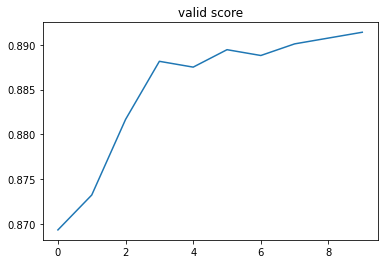

In [12]:
if __name__ == '__main__':
    main(0)